In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

plt.rcParams["figure.figsize"] = (20,10)

# Dataset

The [dataset](https://www.kaggle.com/ronitf/heart-disease-uci) features a binary target variable indicating whether or not a patient is diagnosed with heart disease (1 = positive diagnosis) based on a number of attrributes assessed at clinical presentation:
1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect


We will try to predict the diagnosis using these attributes.


In [2]:
heart_df = pd.read_csv("heart.csv")
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Initial Model Selection

We first run k-fold cross-validation on a number of classifiers for baseline accuracy:
  1. Logistic Regression
  2. Gaussian Naive Bayes
  3. *k* Nearest Neighbours
  4. Decision Tree
  5. Support Vector Machine

In [3]:
def split_data(include_validation=False):
    
    if include_validation:
        train_length = int(len(heart_df) * 0.6)
        train_ix = np.random.choice(len(heart_df), train_length, replace=False)
        reduced = [x for x in heart_df.index if x not in train_ix]
        valid_ix = np.random.choice(reduced, int(len(heart_df) * 0.2), replace=False)
        test_ix = [x for x in heart_df.index if x not in list(train_ix) + list(valid_ix)]
        
        X_train, y_train = heart_df.loc[train_ix, heart_df.columns!='target'], heart_df.loc[train_ix, 'target']
        X_valid, y_valid = heart_df.loc[valid_ix, heart_df.columns!='target'], heart_df.loc[valid_ix, 'target']
        X_test, y_test = heart_df.loc[test_ix, heart_df.columns!='target'], heart_df.loc[test_ix, 'target']
        
        return X_train, y_train, X_valid, y_valid, X_test, y_test
        
    else: 
        train_length = int(len(heart_df) * 0.8)
        train_ix = np.random.choice(len(heart_df), train_length, replace=False)
        test_ix = [x for x in heart_df.index if x not in train_ix]
    
        X_train, y_train = heart_df.loc[train_ix, heart_df.columns!='target'], heart_df.loc[train_ix, 'target']
        X_test, y_test = heart_df.loc[test_ix, heart_df.columns!='target'], heart_df.loc[test_ix, 'target']
    
        return X_train, y_train, X_test, y_test

def print_results(y_test, preds, display=False):
    acc, prec, rec = accuracy_score(y_test, preds), precision_score(y_test, preds), recall_score(y_test, preds)
    if display:
        print("accuracy: {}%".format(round(acc*100,2)))
        print("precision: {}%".format(round(prec*100,2)))
        print("recall: {}%".format(round(rec*100,2)))
    return acc, prec, rec

In [4]:
def results_row(name, acc_list, prec_list, rec_list):
    return [
        name,
        max(acc_list),
        min(acc_list),
        np.mean(acc_list),
        max(prec_list),
        min(prec_list),
        np.mean(prec_list),
        max(rec_list),
        min(rec_list),
        np.mean(rec_list)
    ]

def cross_validate(k):
    results = []
    
    # Logistic Regression
    acc_list = []
    prec_list = []
    rec_list = []
    
    for i in range(0, k):
        X_train, y_train, X_test, y_test = split_data()
        lr_fit = LogisticRegression(max_iter=10000).fit(X_train, y_train)
        preds = lr_fit.predict(X_test)
        acc, prec, rec = print_results(y_test, preds)
        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        
    results.append(results_row('Logistic Regression', acc_list, prec_list, rec_list))
    
    # Gaussian NB
    acc_list = []
    prec_list = []
    rec_list = []
    
    for i in range(0, k):
        X_train, y_train, X_test, y_test = split_data()
        gnb_fit = GaussianNB().fit(X_train, y_train)
        preds = gnb_fit.predict(X_test)
        acc, prec, rec = print_results(y_test, preds)
        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        
    results.append(results_row('Gaussian NB', acc_list, prec_list, rec_list))
    
    # kNN
    acc_list = []
    prec_list = []
    rec_list = []
    
    for i in range(0, k):
        X_train, y_train, X_test, y_test = split_data()
        knn_fit = KNeighborsClassifier().fit(X_train, y_train)
        preds = knn_fit.predict(X_test)
        acc, prec, rec = print_results(y_test, preds)
        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        
    results.append(results_row('kNN', acc_list, prec_list, rec_list))
    
    # Decision Tree
    acc_list = []
    prec_list = []
    rec_list = []
    
    for i in range(0, k):
        X_train, y_train, X_test, y_test = split_data()
        knn_fit = DecisionTreeClassifier().fit(X_train, y_train)
        preds = knn_fit.predict(X_test)
        acc, prec, rec = print_results(y_test, preds)
        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        
    results.append(results_row('Decision Tree', acc_list, prec_list, rec_list))
    
    # SVM
    acc_list = []
    prec_list = []
    rec_list = []
    
    for i in range(0, k):
        X_train, y_train, X_test, y_test = split_data()
        svm_fit = SVC().fit(X_train, y_train)
        preds = svm_fit.predict(X_test)
        acc, prec, rec = print_results(y_test, preds)
        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        
    results.append(results_row('SVM', acc_list, prec_list, rec_list))
    
    results_df = pd.DataFrame(results, columns=[
        'classifier',
        'max_accuracy',
        'min_accuracy',
        'mean_accuracy',
        'max_precision',
        'min_precision',
        'mean_precision',
        'max_recall',
        'min_recall',
        'mean_recall',
    ])
    
    return results_df

In [5]:
baseline_results = cross_validate(10).sort_values(by='mean_accuracy')

We observe that the Logistic Regression and Naive Bayes classifiers offer the most consistent baseline accuracy. The Decision Tree classifier offers sporadically high accuracy as a result of generally extreme values - this may be worth investigating later.

# Naive Bayes 

In [6]:
baseline_results[baseline_results['classifier']=='Gaussian NB']

,classifier,max_accuracy,min_accuracy,mean_accuracy,max_precision,min_precision,mean_precision,max_recall,min_recall,mean_recall
1,Gaussian NB,0.868852,0.770492,0.819672,0.9375,0.75,0.820075,0.916667,0.724138,0.849079


## Hyperparameter Optimization

### Variance Smoothing

In [7]:
X_train, y_train, X_valid, y_valid, X_test, y_test  = split_data(include_validation=True)

x,y = [], []
for i in range(0, 1000):
    p = 0.000000000001 * (1.1**i)
    if p > 0.001:
        break
    gnb_fit = GaussianNB(var_smoothing=p).fit(X_train, y_train)
    preds = gnb_fit.predict(X_valid)
    acc, prec, rec = print_results(y_valid, preds)
    x.append(p)
    y.append(acc)
    
vs_df = pd.DataFrame([
    [x[i], y[i]] for i in range(0, len(x))
], columns=['var_smoothing', 'accuracy']).sort_values(by='accuracy', ascending=False).reset_index(drop=True)

opt_vs = vs_df.loc[0]['var_smoothing']
vs_df.head(10)

,var_smoothing,accuracy
0,1.000000e-12,0.85
1,1.100000e-12,0.85
2,1.667454e-08,0.85
3,1.834200e-08,0.85
4,2.017619e-08,0.85
5,2.219381e-08,0.85
6,2.441320e-08,0.85
7,2.685451e-08,0.85
8,2.953997e-08,0.85
9,3.574336e-08,0.85


Text(0.0, 1.0, 'Gaussian Naive Bayes Hyperparameter Optimization: Variance Smoothing')

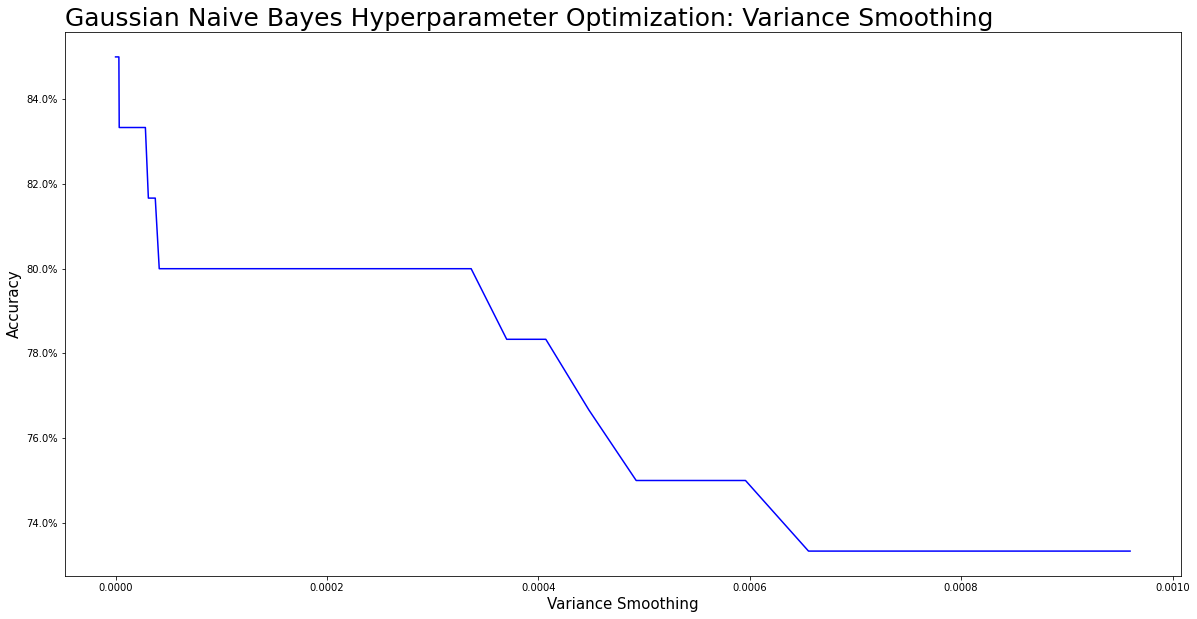

In [8]:
plt_y = [100*yi for yi in y]

fig, ax = plt.subplots()
ax.plot(x,plt_y, color='blue')

ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())

plt.xlabel("Variance Smoothing", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Gaussian Naive Bayes Hyperparameter Optimization: Variance Smoothing", fontsize=25, loc="left")

### Class Priors

In [9]:
probs, mean_accuracies, max_accuracies, min_accuracies = [], [], [], []

for i in range(0, 99):
    p1 = 0.01 + i/100
    p2 = 1 - p1
    probs.append(p1)
    p_acc = []
    for i in range(0, 10):
        X_train, y_train, X_valid, y_valid, X_test, y_test  = split_data(include_validation=True)
        gnb_fit = GaussianNB(priors=(p1,p2), var_smoothing=opt_vs).fit(X_train, y_train)
        preds = gnb_fit.predict(X_valid)
        p_acc.append(accuracy_score(y_valid, preds))
    mean_accuracies.append(np.mean(p_acc))
    max_accuracies.append(np.max(p_acc))
    min_accuracies.append(np.min(p_acc))
    
cp_df = pd.DataFrame([
    [probs[i], 1-probs[i], mean_accuracies[i], min_accuracies[i], max_accuracies[i]]
    for i in range(0, len(probs))
], columns=['P1', 'P2', 'mean_accuracy', 'min_accuracy', 'max_accuracy']).sort_values(
    by='mean_accuracy', ascending=False
).reset_index(drop=True)

opt_cp = (cp_df.loc[0]['P1'], cp_df.loc[0]['P2'])
cp_df.head(10)

,P1,P2,mean_accuracy,min_accuracy,max_accuracy
0,0.56,0.44,0.851667,0.816667,0.900000
1,0.42,0.58,0.840000,0.750000,0.900000
2,0.62,0.38,0.840000,0.800000,0.883333
3,0.39,0.61,0.836667,0.750000,0.916667
4,0.05,0.95,0.835000,0.750000,0.900000
5,0.19,0.81,0.835000,0.766667,0.916667
6,0.36,0.64,0.831667,0.766667,0.916667
7,0.52,0.48,0.830000,0.783333,0.900000
8,0.37,0.63,0.830000,0.783333,0.933333
9,0.23,0.77,0.830000,0.783333,0.866667


Text(0.0, 1.0, 'Gaussian Naive Bayes Hyperparameter Optimization: Class Priors')

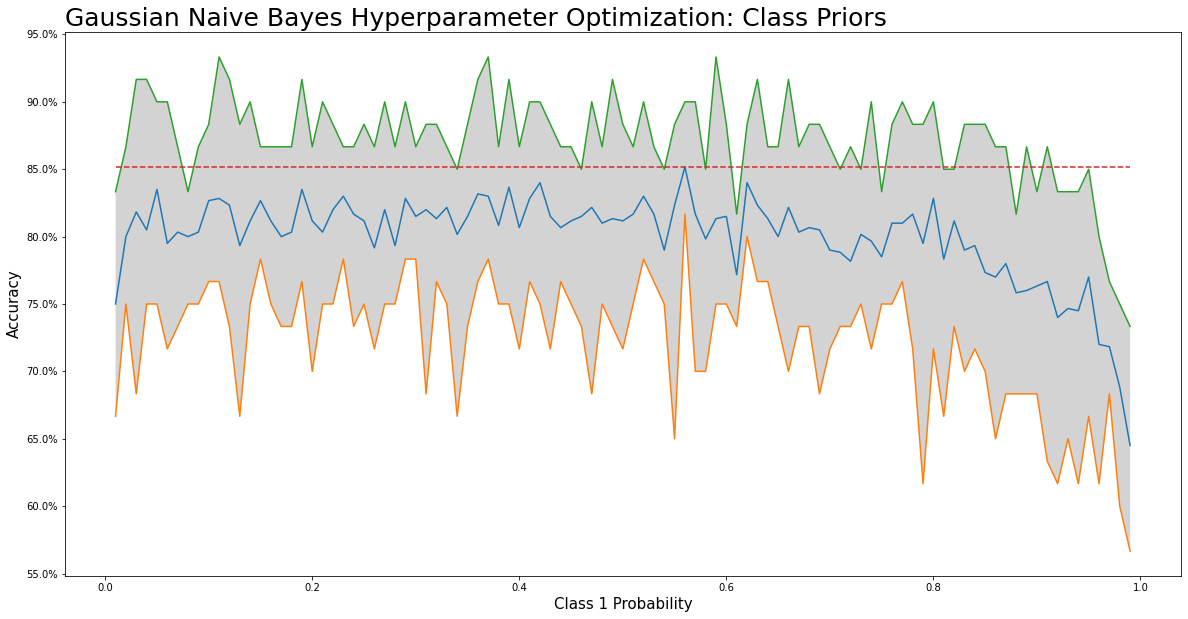

In [10]:
plt_mean = [x * 100 for x in mean_accuracies]
plt_min = [x * 100 for x in min_accuracies]
plt_max = [x * 100 for x in max_accuracies]

fig, ax = plt.subplots()
ax.plot(probs, plt_mean)
ax.plot(probs, plt_min)
ax.plot(probs, plt_max)
ax.fill_between(probs, plt_min, plt_max, facecolor='lightgrey')
ax.plot(probs, np.repeat(max(plt_mean), len(probs)), linestyle='dashed')

ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())

plt.xlabel("Class 1 Probability", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Gaussian Naive Bayes Hyperparameter Optimization: Class Priors", fontsize=25, loc="left")


In [129]:
gnb_baseline = baseline_results[baseline_results['classifier']=='Gaussian NB']

acc_list = []
prec_list = []
rec_list = []

for i in range(0, 10):
    X_train, y_train, X_test, y_test = split_data()
    gnb_fit = GaussianNB(
        var_smoothing=opt_vs,
        priors=opt_cp
    ).fit(X_train, y_train)
    preds = gnb_fit.predict(X_test)
    acc, prec, rec = print_results(y_test, preds)
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)

pd.DataFrame(
    [results_row('Optimized Gaussian NB', acc_list, prec_list, rec_list),
     ['Baseline Gaussian NB'] + list(gnb_baseline.loc[1,gnb_baseline.columns != 'classifier'])
    ], 
    columns=[
        'classifier',
        'max_accuracy',
        'min_accuracy',
        'mean_accuracy',
        'max_precision',
        'min_precision',
        'mean_precision',
        'max_recall',
        'min_recall',
        'mean_recall',
    ])

,classifier,max_accuracy,min_accuracy,mean_accuracy,max_precision,min_precision,mean_precision,max_recall,min_recall,mean_recall
0,Optimized Gaussian NB,0.852459,0.704918,0.780328,0.967742,0.6875,0.834372,0.861111,0.714286,0.772406
1,Baseline Gaussian NB,0.868852,0.770492,0.819672,0.937500,0.7500,0.820075,0.916667,0.724138,0.849079
